In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


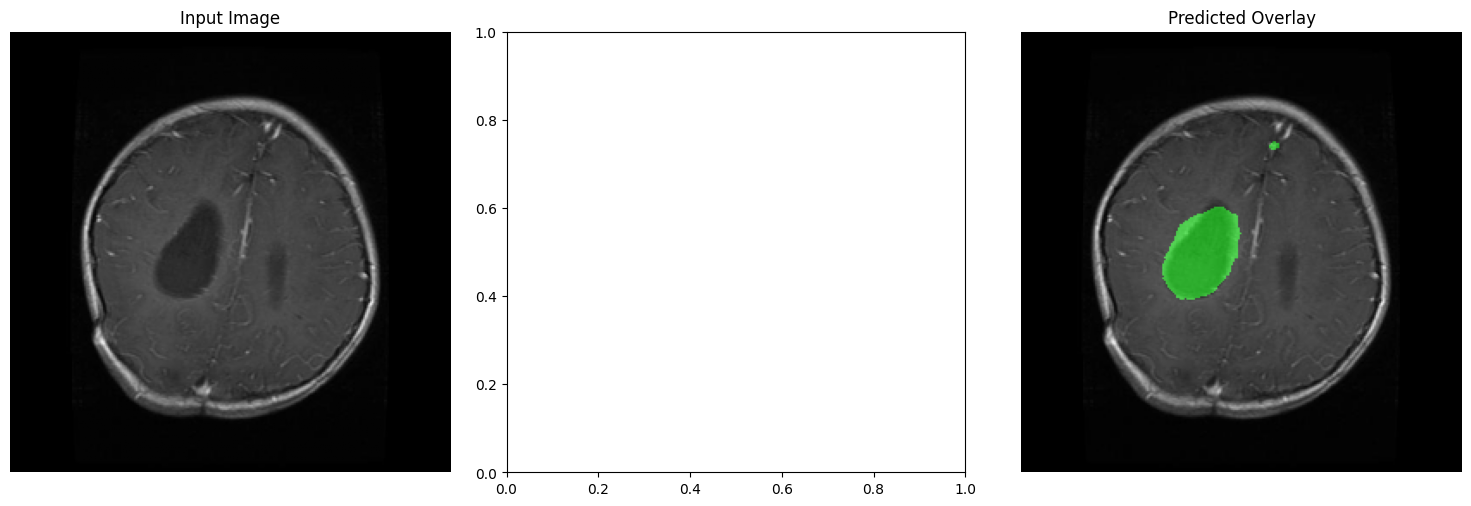

Test completed. Predicted mask displayed.


In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from patchify import patchify
import matplotlib.pyplot as plt  # For displaying images in the notebook

# UNETR Configuration
cf = {
    "image_size": 256,  # Input image size (must match the size the model was trained on)
    "num_channels": 3,  # Number of channels in the input (RGB)
    "patch_size": 16,   # Patch size used for the model
}
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"] * cf["patch_size"] * cf["num_channels"]
)

# Dice Coefficient and Loss Functions
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def load_and_preprocess_image(image_path):
    """ Load and preprocess the image (resize, normalize, patchify) """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0  # Normalize to [0, 1]

    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)  # Add batch dimension
    return image, patches  # Return both the original image and the patches

def overlay_mask_on_image(image, mask, alpha=0.5, color=(0, 255, 0)):
    """ Overlay the mask on the image with transparency. """
    image = (image * 255).astype(np.uint8)  # Convert the image to uint8 (from float32)
    mask = (mask * 255).astype(np.uint8)  # Convert the mask to uint8

    # Convert mask to 3 channels
    mask_colored = np.zeros_like(image, dtype=np.uint8)
    mask_colored[:, :, 1] = mask  # Apply the green channel with mask intensity

    # Blend the image with the mask
    blended = cv2.addWeighted(image, 1.0, mask_colored, alpha, 0)
    return blended

def display_images(input_image, predicted_mask):
    """ Display the input image with overlayed ground truth and predicted masks """
    # Overlay ground truth and predicted masks
   # overlay_gt = overlay_mask_on_image(input_image, ground_truth_mask)
    overlay_pred = overlay_mask_on_image(input_image, predicted_mask)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Show the original image, ground truth overlay, and predicted overlay
    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')

 #   axes[1].imshow(overlay_gt)
 #   axes[1].set_title("Ground Truth Overlay")
 #   axes[1].axis('off')

    axes[2].imshow(overlay_pred)
    axes[2].set_title("Predicted Overlay")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set the paths
    model_path = "D:\\hirmuzesh\\best_model(1).keras"  # Path to your trained model
    image_path = "D:\\hirmuzesh\\vit-brain-tumor\\archive\\Testing\\glioma\\Te-gl_0018.jpg"  # Path to your test image
 #   ground_truth_path = "D:\\Brain_Tumor_Final\\masks\\12.png"  # Path to the corresponding ground truth mask

    # Load the model
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

    # Load and preprocess the image and ground truth mask
    input_image, input_patches = load_and_preprocess_image(image_path)

    # Load the ground truth mask
  #  ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
  #  ground_truth_mask = cv2.resize(ground_truth_mask, (cf["image_size"], cf["image_size"])) / 255.0  # Normalize to [0, 1]

    # Make the prediction
    pred = model.predict(input_patches, verbose=0)[0]
    pred_resized = cv2.resize(pred, (cf["image_size"], cf["image_size"]))  # Resize to original image size
    pred_resized = np.where(pred_resized > 0.5, 1.0, 0.0)  # Binarize the prediction

    # Display the images: input, ground truth, and predicted mask overlays
    display_images(input_image, pred_resized)

    print("Test completed. Predicted mask displayed.")


In [6]:
! pip install transformer


ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for transformer


In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from transformer import TumorClassifierViT



In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = TumorClassifierViT(num_classes=4)
model.load_state_dict(torch.load('D:\\hirmuzesh\\vit-brain-tumor\\best_model.pth'))
model.to(device)
model.eval()



TumorClassifierViT(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
 

In [16]:
# Define the transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Predicted class: glioma
Confidence: 99.9994158744812%
[9.9999416e-01 5.8625237e-06 1.3960114e-09 9.0359498e-09]


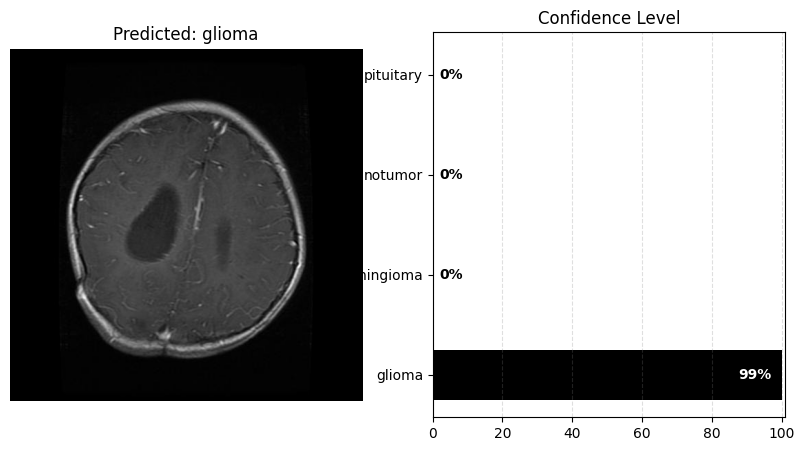

In [17]:
# Function to predict a single image
def predict_image(image_path, model, transform, device):
    # Open image
    image = Image.open(image_path).convert('RGB')
    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    
    confidence, predicted = torch.max(probabilities, 0)
    
    return predicted.item(), confidence.item(), probabilities.cpu().numpy(), image

# Path to the image
image_path = 'D:\\hirmuzesh\\vit-brain-tumor\\archive\\Testing\\glioma\\Te-gl_0018.jpg'  # replace with your image path

# Predict the class
predicted_class, confidence, probabilities, image = predict_image(image_path, model, data_transforms, device)

# Define class names (assuming you know the class order)
train_dataset = ImageFolder('D:\\hirmuzesh\\vit-brain-tumor\\archive\\Training', transform=data_transforms)
class_names = train_dataset.classes

# Print predicted class and confidence
print(f'Predicted class: {class_names[predicted_class]}')
print(f'Confidence: {confidence * 100}%')

# Create subplots: one for the image, one for the bar chart
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the image on the left subplot
axs[0].imshow(image)
axs[0].set_title(f'Predicted: {class_names[predicted_class]}')
axs[0].axis('off')

# Display the bar chart on the right subplot
print(probabilities)
multiply = lambda items: list(map(lambda x: x * 100, items))

rects = axs[1].barh(range(len(class_names)), multiply(probabilities),  align='center',
                     height=0.5, color='black')
axs[1].set_yticks(range(len(class_names)))
axs[1].set_yticklabels(class_names)
axs[1].set_xlim([0, 101]) 
axs[1].set_title('Confidence Level')
axs[1].xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

rect_labels = []
# Lastly, write in the ranking inside each bar to aid in interpretation
for rect in rects:
    # Rectangle widths are already integer-valued but are floating
    # type, so it helps to remove the trailing decimal point and 0 by
    # converting width to int type
    width = int(rect.get_width())

    rankStr = f"{width}%"
    # The bars aren't wide enough to print the ranking inside
    if width < 40:
        # Shift the text to the right side of the right edge
        xloc = 5
        # Black against white background
        clr = 'black'
        align = 'left'
    else:
        # Shift the text to the left side of the right edge
        xloc = -5
        # White on magenta
        clr = 'white'
        align = 'right'

    # Center the text vertically in the bar
    yloc = rect.get_y() + rect.get_height() / 2
    label = axs[1].annotate(rankStr, xy=(width, yloc), xytext=(xloc, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=clr, weight='bold', clip_on=True)
    rect_labels.append(label)



In [18]:
# Save the figure to disk
output_path = 'D:\\hirmuzesh\\vit-brain-tumor\\prediction_result.png' 
plt.savefig(output_path, bbox_inches='tight')
print(f'Figure saved to {output_path}')

# Show the figure
plt.show()


Figure saved to D:\hirmuzesh\vit-brain-tumor\prediction_result.png


<Figure size 640x480 with 0 Axes>